---
title: "Understanding the biology of diseases"
author: "Saikat Banerjee"
format:
  html: default
date: "2024-03-18"
file-modified: "2024-03-18"
abstract: "We attempt to characterize the biology of diseases from the low dimensional representation of the PanUKB summary statistics."

---

In [3]:
import os
import re
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from adjustText import adjust_text
import textalloc
import umap

from scipy.cluster import hierarchy as sp_hierarchy
from scipy.spatial import procrustes as sp_procrustes

from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')
from matplotlib.gridspec import GridSpec

import sys
sys.path.append("../utils/")
import simulate as mpy_simulate
import plot_functions as mpy_plotfn

from bokeh.plotting import figure as bokeh_figure
from bokeh.plotting import show as bokeh_show
from bokeh.io import output_notebook
from bokeh.models import ColumnDataSource

output_notebook()

Loading BokehJS ...

In [5]:
source = ColumnDataSource(data=dict(
    x=[1, 2, 3, 4, 5],
    y=[2, 5, 8, 2, 7],
    desc=['A', 'b', 'C', 'd', 'E'],
))

TOOLTIPS = [
    ("index", "$index"),
    ("(x,y)", "($x, $y)"),
    ("desc", "@desc"),
]

p = bokeh_figure(width=400, height=400, tooltips=TOOLTIPS,
           title="Mouse over the dots")

p.scatter('x', 'y', size=20, source=source)

bokeh_show(p)

In [2]:
data_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/data"
result_dir = "/gpfs/commons/home/sbanerjee/work/npd/PanUKB/results/nnsparsh/full/"

zscore_df = pd.read_pickle(os.path.join(data_dir, f"modselect/zscore_all.pkl"))
trait_df  = pd.read_pickle(os.path.join(data_dir, f"modselect/traits_all.pkl"))

variant_filename = f"{data_dir}/allvar.pruned.closesttss.hugo"
variant_df       = pd.read_csv(variant_filename, sep = '\t')

In [4]:
method = 'nnm_sparse'

In [5]:
res_filename = os.path.join(result_dir, f"{method}_model.pkl")
with (open(res_filename, "rb")) as fh:
    lowrank_model = pickle.load(fh)

In [6]:
lowrank_model.keys()

dict_keys(['max_iter_', 'model_', 'svd_method_', 'svd_max_iter_', 'simplex_method_', 'stop_criteria_', 'tol_', 'step_size_tol_', 'fxrel_tol_', 'show_progress_', 'prog_step_skip_', 'is_debug_', 'suppress_warnings_', 'is_benchmark_', 'benchmark_method_', 'weight_', 'mask_', 'weight_mask_', 'Y_', 'rank_', 'l1_thres_', 'fm_list_', 'fl_list_', 'fx_list_', 'dg_list_', 'st_list_', 'cpu_time_', 'convergence_msg_', 'X_', 'M_'])

In [44]:
X = np.array(zscore_df.drop(labels = ['rsid'], axis = 1).values.T)
X_cent = X - np.mean(X, axis = 0, keepdims = True)
lowX = lowrank_model['X_']
lowX_cent = lowX - np.mean(lowX, axis = 0, keepdims = True)
lowX_std = lowX_cent / np.sqrt(np.prod(lowX_cent.shape))

print ("Nuclear Norms")
print (f"Low rank model: {np.linalg.norm(lowX, ord = 'nuc'):.3f}")
print (f"Input data: {np.linalg.norm(X, ord = 'nuc'):.3f}")
print (f"Input data (mean centered): {np.linalg.norm(X_cent, ord = 'nuc'):.3f}")

Nuclear Norms
Low rank model: 8050.750
Input data: 496751.155
Input data (mean centered): 495872.387


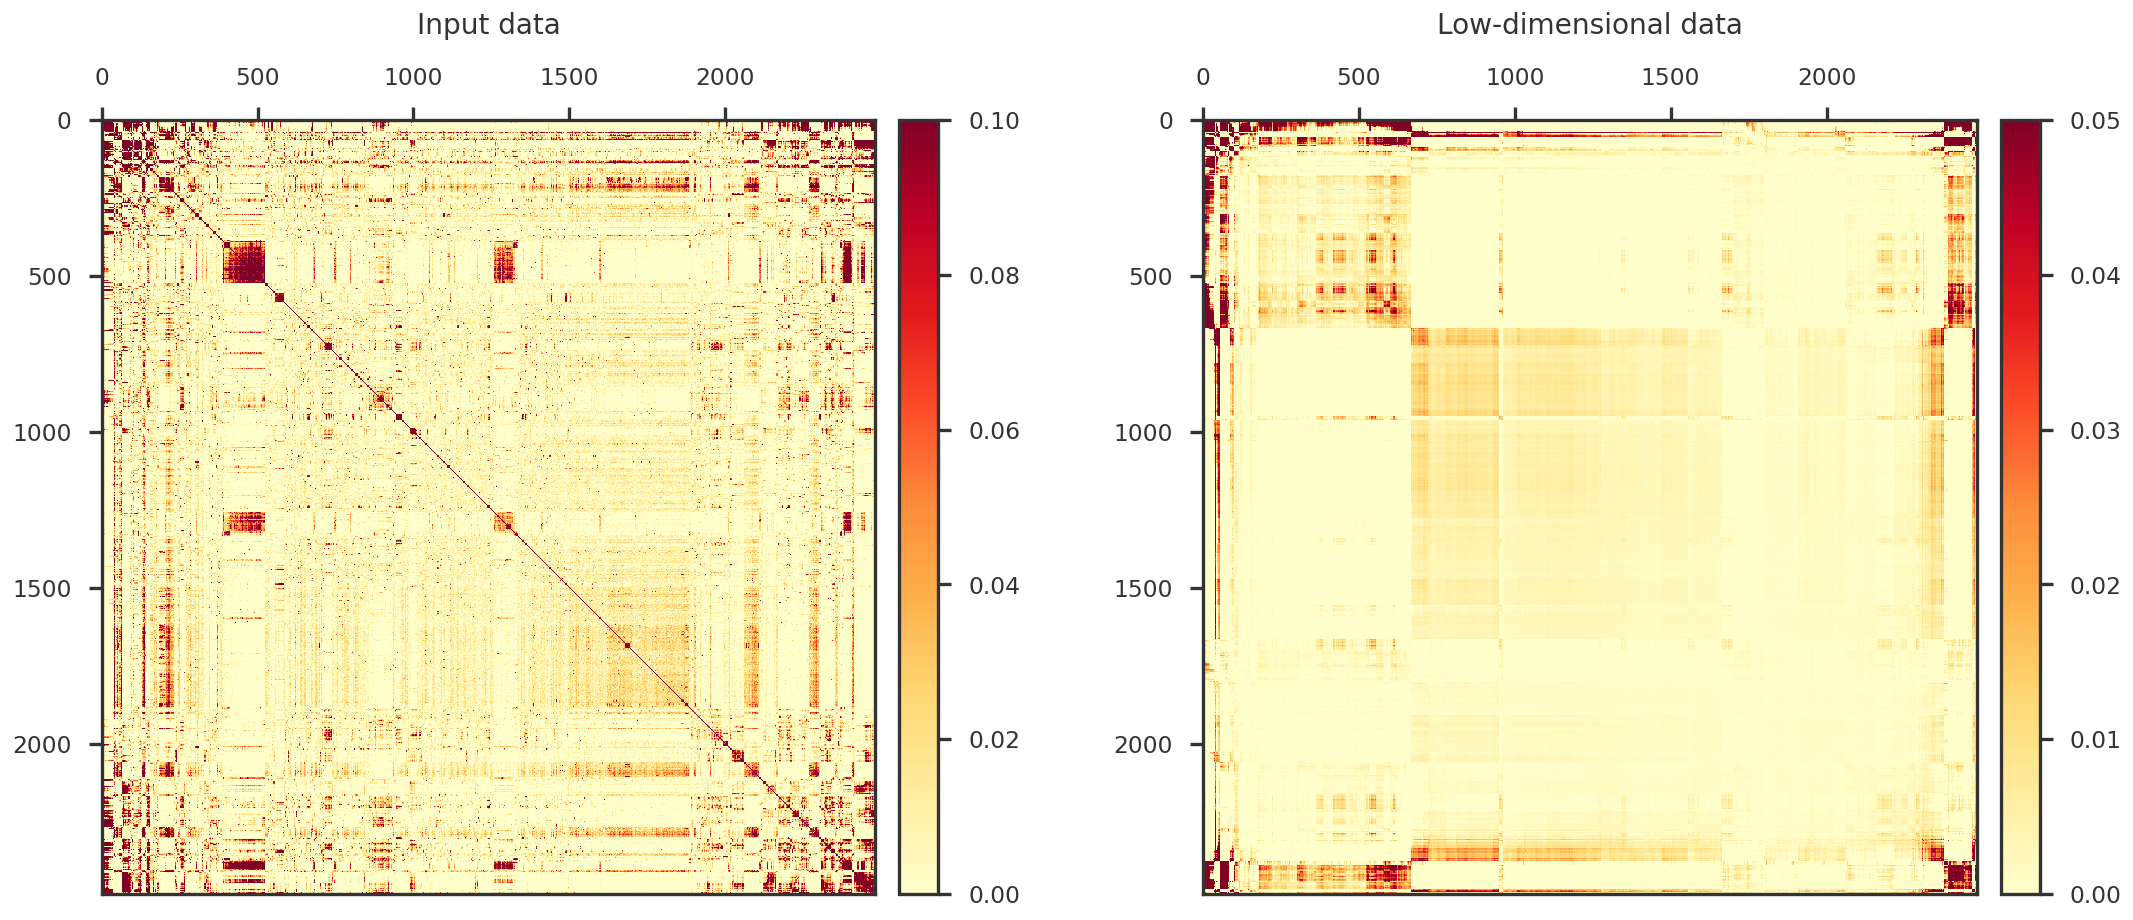

In [50]:
# o1 = sp_hierarchy.leaves_list(sp_hierarchy.linkage(np.cov(X_cent), method = 'centroid'))
# o2 = sp_hierarchy.leaves_list(sp_hierarchy.linkage(np.cov(lowX_std), method = 'centroid'))

fig = plt.figure(figsize = (18, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

mpy_plotfn.plot_covariance_heatmap(ax1, X_cent[o1, :], vmax = 0.1)
mpy_plotfn.plot_covariance_heatmap(ax2, lowX_cent[o2, :], vmax = 0.05)

ax1.set_title("Input data", pad = 20)
ax2.set_title("Low-dimensional data", pad = 20)
plt.tight_layout(w_pad = 4.0)
plt.show()

In [111]:
def compute_loadings_factors(X, k = None):
    #X_cent = mpy_simulate.do_standardize(X, scale = False)
    #X_cent /= np.sqrt(np.prod(X_cent.shape))
    U, S, Vt = np.linalg.svd(X, full_matrices = False)
    S2 = np.square(S)
    explained_variance = S2 / np.sum(S2)
    if k is None:
        k = np.where(explained_variance < 1e-12)[0][0] - 1
    U_low = U[:, :k]
    S_low = S[:k]
    factors = Vt[:k, :].T
    loadings = U_low @ np.diag(S_low)
    return U_low, S_low, loadings, factors

U0, S0, loadings0, factors0 = compute_loadings_factors(lowX)
U1, S1, loadings1, factors1 = compute_loadings_factors(lowX_std)
U2, S2, loadings2, factors2 = compute_loadings_factors(X_cent)

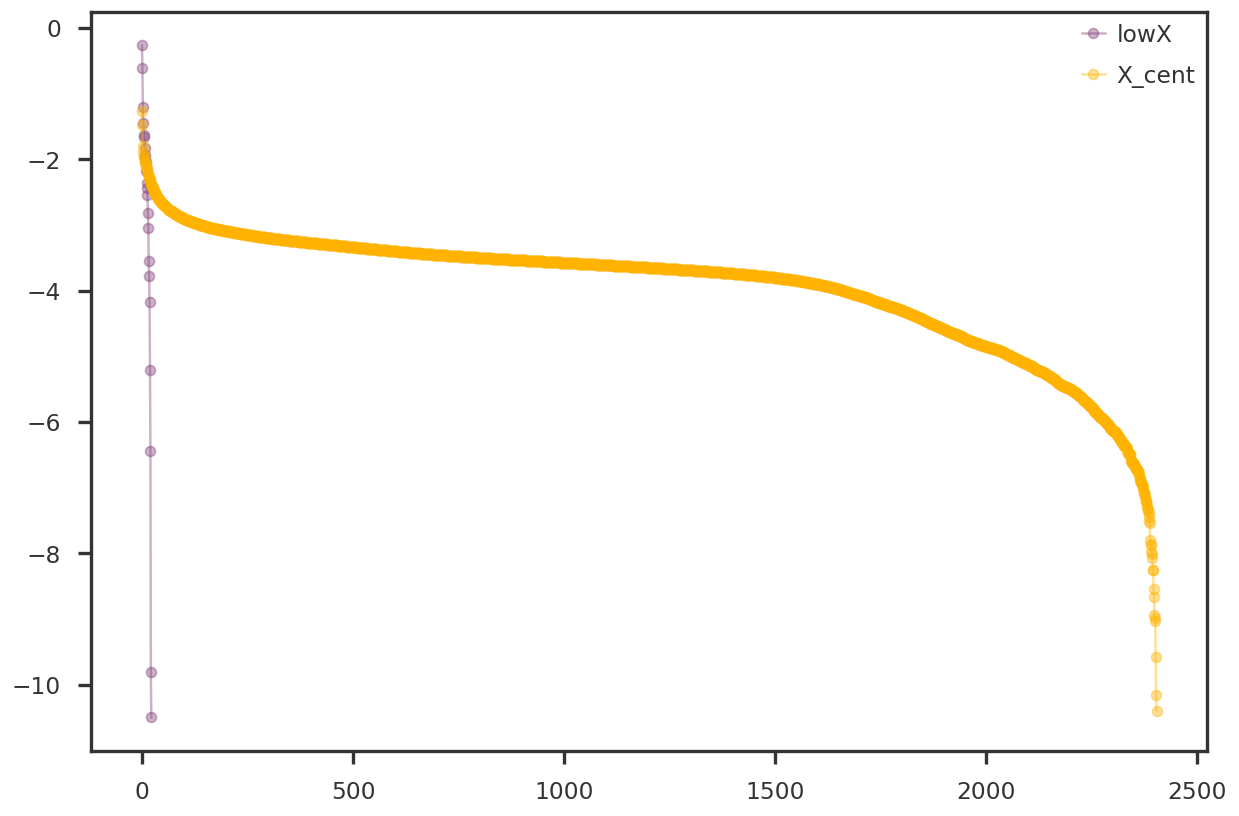

In [113]:
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(111)
ax1.plot(np.arange(S0.shape[0]), np.log10(np.square(S0) / np.sum(np.square(S0))), marker = 'o', label = 'lowX', alpha = 0.4)
#ax1.plot(np.arange(S1.shape[0]), np.log10(np.square(S1) / np.sum(np.square(S1))), marker = 'o', label = 'lowX_std', alpha = 0.4)
ax1.plot(np.arange(S2.shape[0]), np.log10(np.square(S2) / np.sum(np.square(S2))), marker = 'o', label = 'X_cent', alpha = 0.4)
ax1.legend()
plt.show()

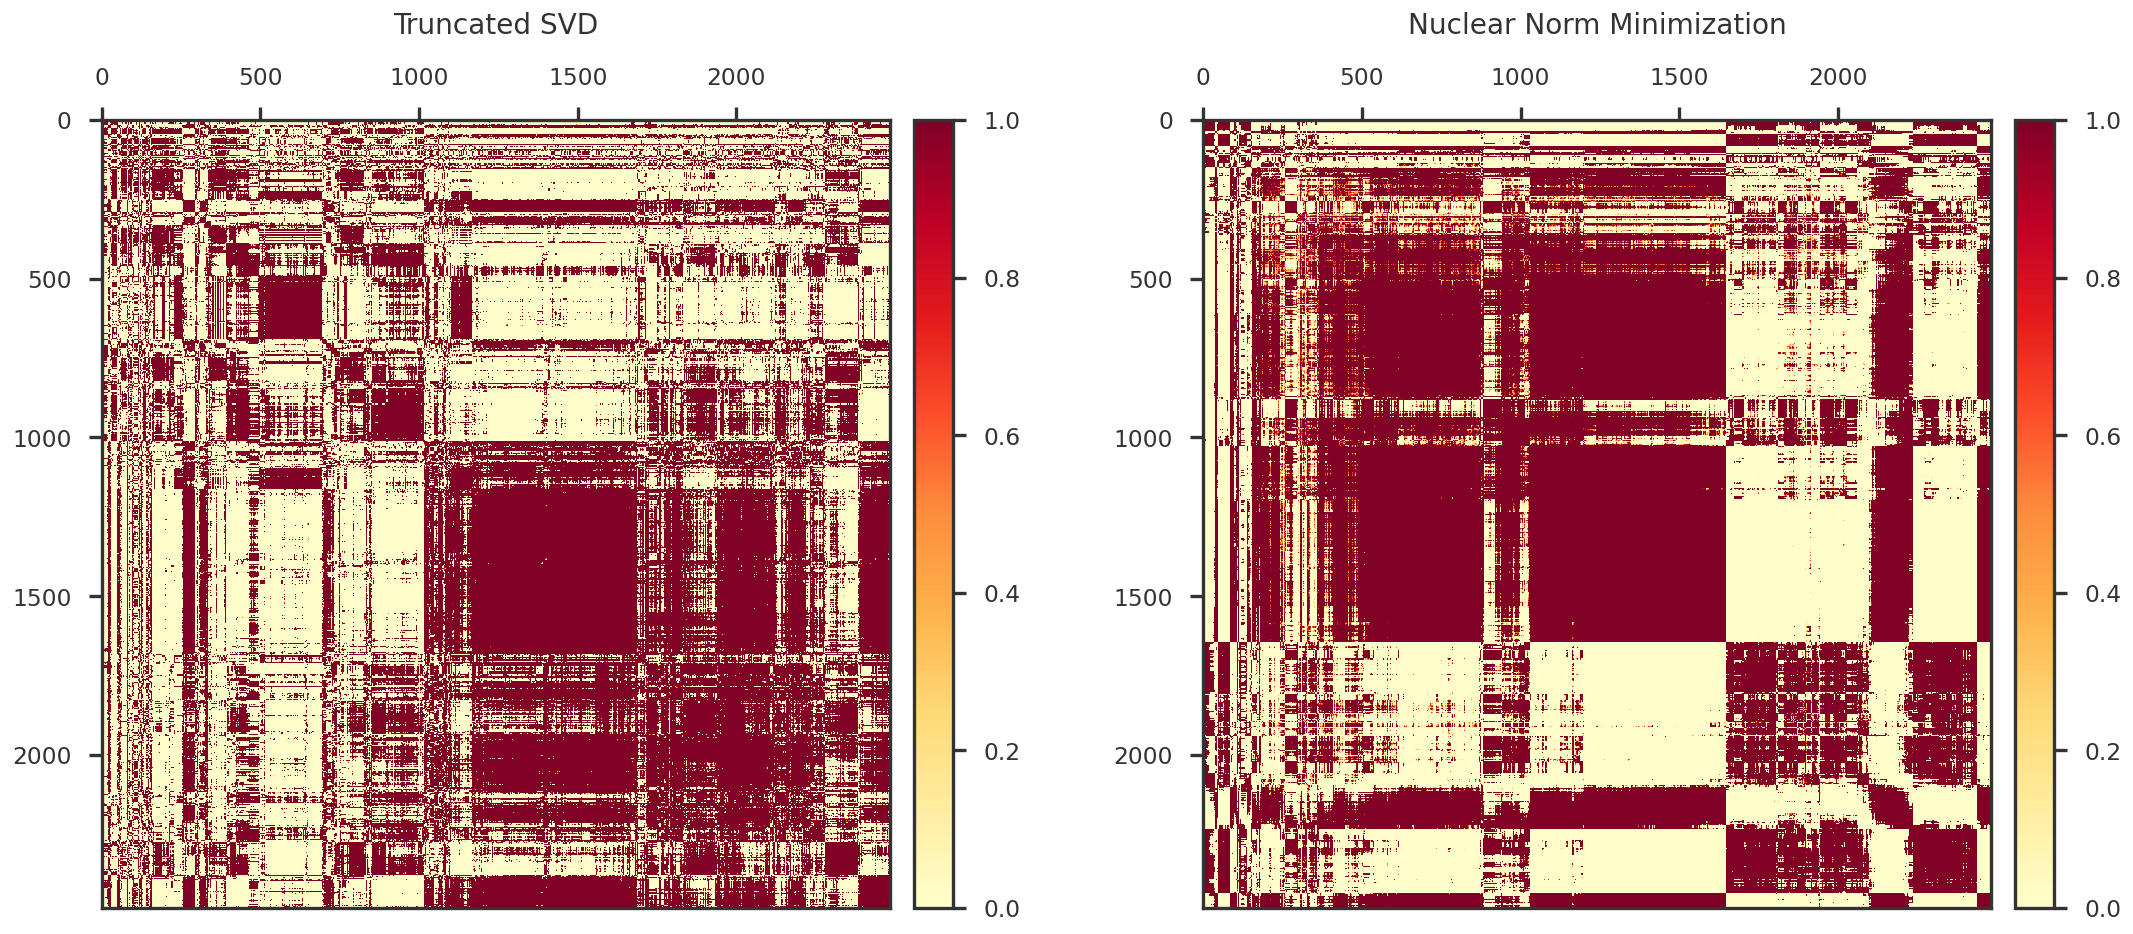

In [169]:
nnm_loadings  = loadings0.copy()
tsvd_loadings = U2[:, :loadings0.shape[1]] @ np.diag(S2[:loadings0.shape[1]])

o1 = sp_hierarchy.leaves_list(sp_hierarchy.linkage(np.cov(tsvd_loadings), method = 'centroid'))
o2 = sp_hierarchy.leaves_list(sp_hierarchy.linkage(np.cov(nnm_loadings), method = 'centroid'))

fig = plt.figure(figsize = (18, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

mpy_plotfn.plot_covariance_heatmap(ax1, tsvd_loadings[o1, :])
mpy_plotfn.plot_covariance_heatmap(ax2, nnm_loadings[o2, :])

ax1.set_title("Truncated SVD", pad = 20)
ax2.set_title("Nuclear Norm Minimization", pad = 20)
plt.tight_layout(w_pad = 4.0)
plt.show()

In [170]:
no_prescription_idx = trait_df[trait_df['trait_type'] != 'prescriptions'].index
nnm_loadings_noprescription  = nnm_loadings[no_prescription_idx, :]
tsvd_loadings_noprescription = tsvd_loadings[no_prescription_idx, :]

In [262]:
import umap
nnm_reducer = umap.UMAP(
    n_neighbors = 10, metric = 'cosine', min_dist = 0.4,
)
nnm_embedding = nnm_reducer.fit_transform(nnm_loadings_noprescription)

tsvd_reducer = umap.UMAP(
    n_neighbors = 10, metric = 'cosine', min_dist = 0.4,
)
tsvd_embedding = tsvd_reducer.fit_transform(tsvd_loadings_noprescription)

In [260]:
trait_type_dict = {
    trait: color for trait, color in zip(
        trait_df['trait_type'].unique().tolist(), 
        mpl_stylesheet.banskt_colors()[:len(trait_df['trait_type'].unique())])
    }

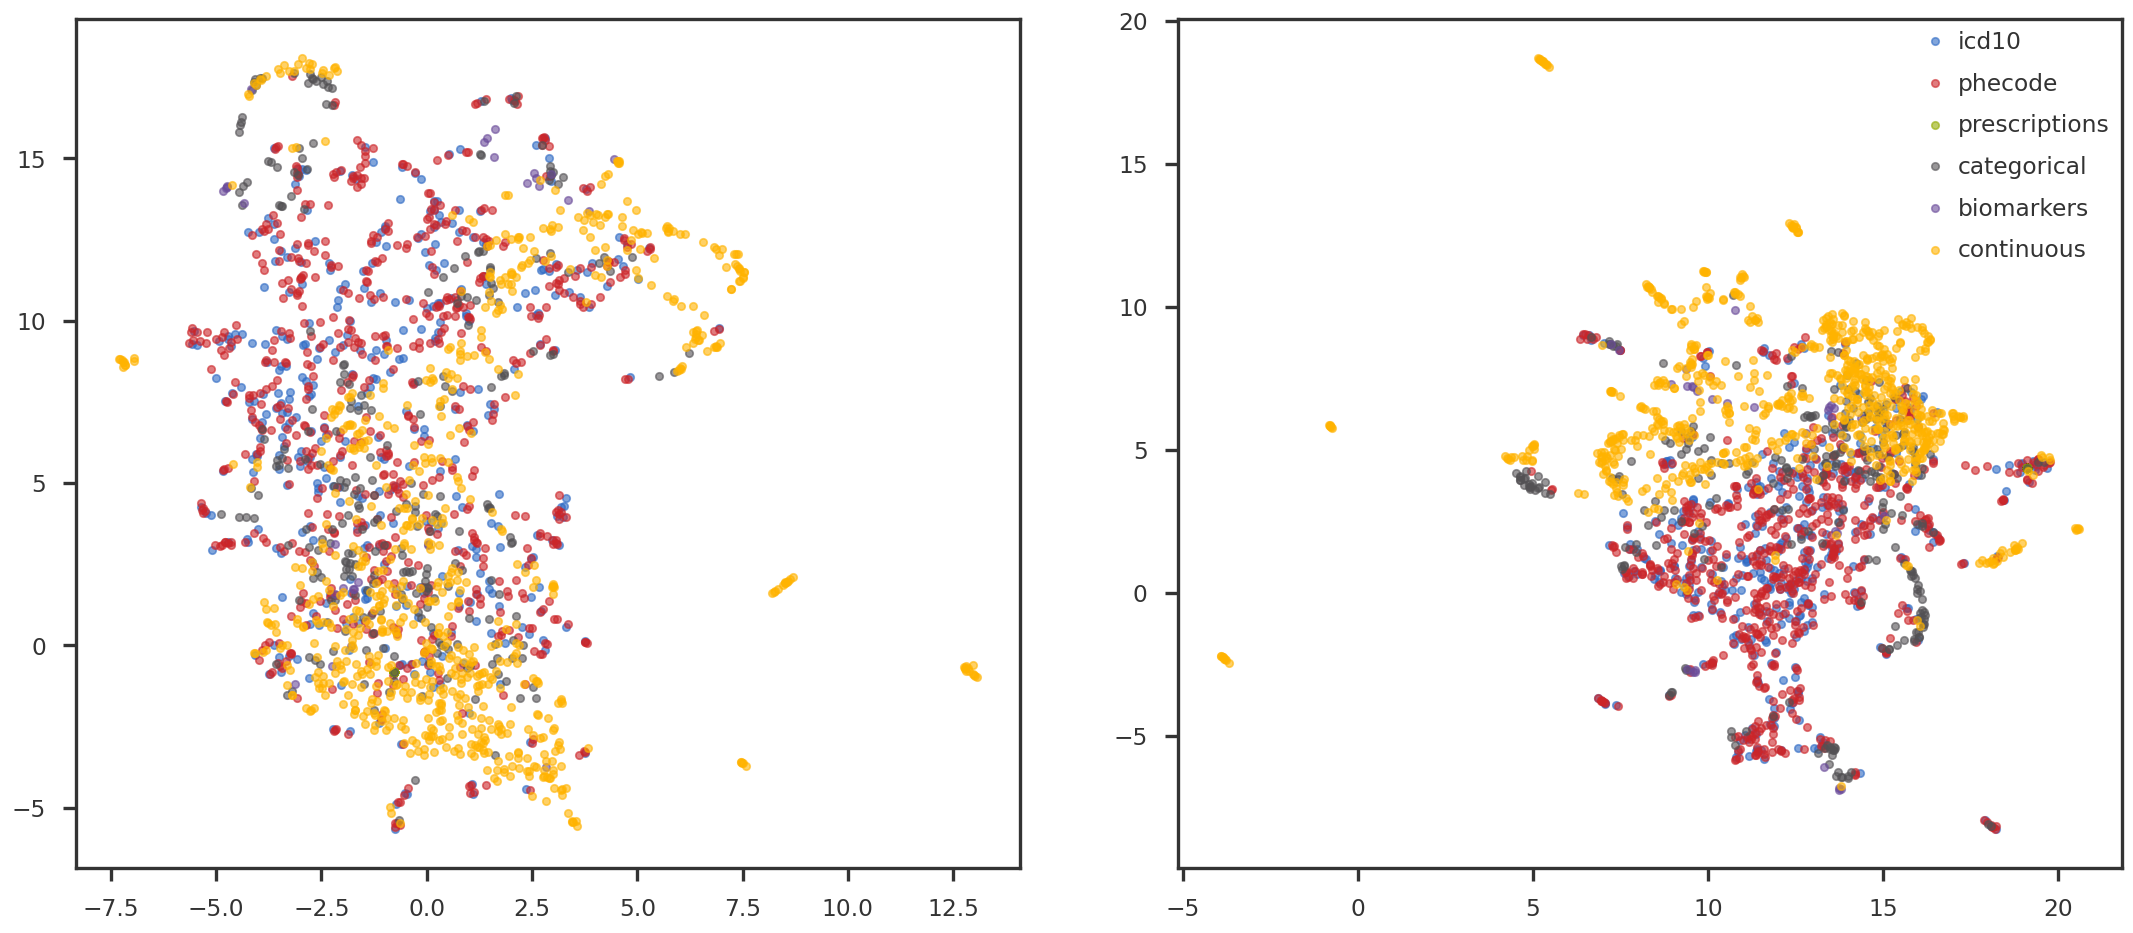

In [272]:
nnm_reducer = umap.UMAP(
    n_neighbors = 10, metric = 'cosine', min_dist = 0.4,
    set_op_mix_ratio = 0.3,
    #densmap=True, dens_lambda=1.0,
    #random_state = 42,
    target_n_neighbors = 50,
)
nnm_embedding = nnm_reducer.fit_transform(nnm_loadings_noprescription)

fig = plt.figure(figsize = (18, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ipc1 = 4
ipc2 = 5

for trait, color in trait_type_dict.items():
    selectidx = np.array(trait_df[trait_df['trait_type'] == trait].index)
    tidx = np.searchsorted(no_prescription_idx, selectidx)
    ax1.scatter(nnm_embedding[tidx, 0], nnm_embedding[tidx, 1], s = 20, alpha = 0.6, color = color, label = trait)
    ax2.scatter(tsvd_embedding[tidx, 0], tsvd_embedding[tidx, 1], s = 20, alpha = 0.6, color = color, label = trait)
    #ax2.scatter(nnm_loadings_noprescription[tidx, ipc1], nnm_loadings_noprescription[tidx, ipc2], s = 20, alpha = 0.6, color = color, label = trait)

ax2.legend()
plt.tight_layout(w_pad = 4.0)
plt.show()

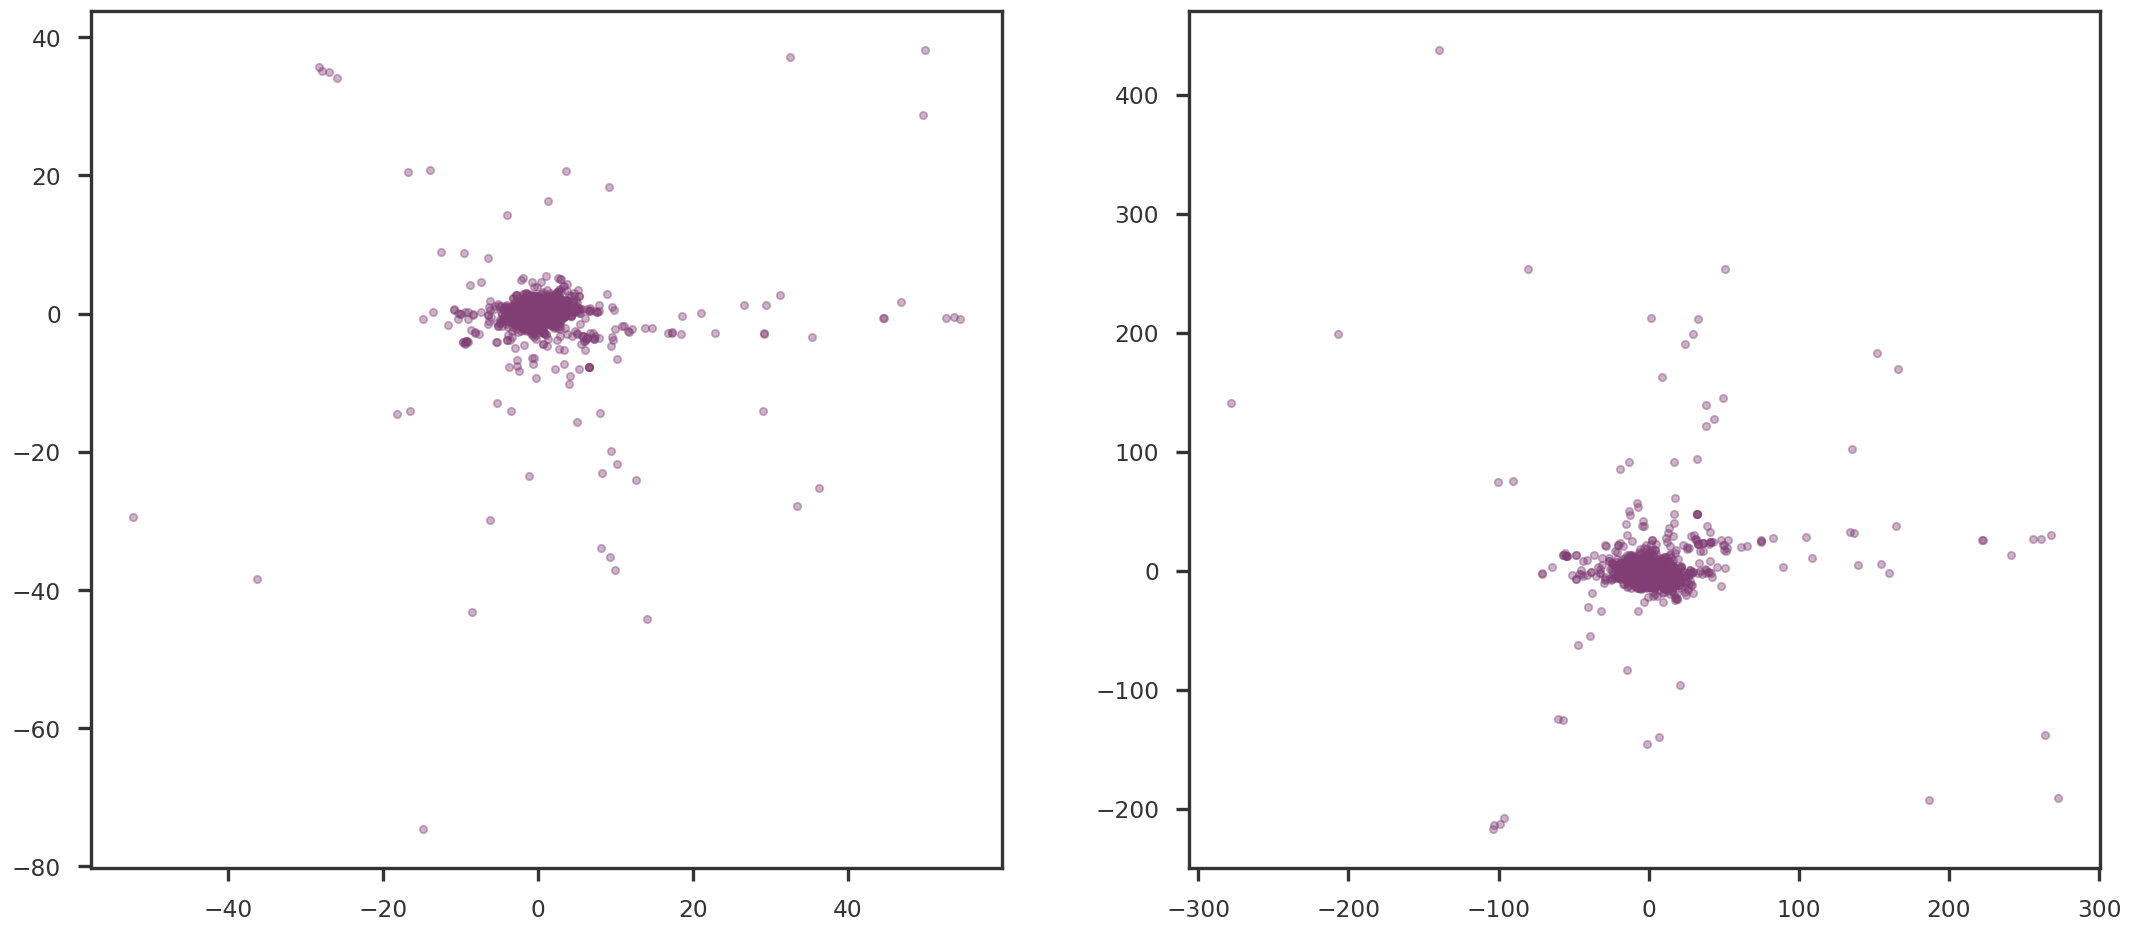

In [104]:
fig = plt.figure(figsize = (18, 8))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ipc1 = 10
ipc2 = 11

ax1.scatter(loadings0[:, ipc1], loadings0[:, ipc2], s = 20, alpha = 0.4)
ax2.scatter(loadings2[:, ipc1], loadings2[:, ipc2], s = 20, alpha = 0.4)

plt.tight_layout(w_pad = 4.0)
plt.show()

In [10]:


def compute_cos(xmat):
    xmat2 = xmat ** 2
    return xmat2 / np.sum(xmat2, axis = 1, keepdims = True)

def compute_contribution(xmat):
    xmat2 = xmat ** 2
    return xmat2 / np.sum(xmat2, axis = 0, keepdims = True)

U, S, loadings, factors = get_principal_components(lowrank_model['X_'])
cos2_pheno   = compute_cos(loadings)
cos2_variant = compute_cos(factors @ np.diag(S))
contribution_pheno   = compute_contribution(loadings)
contribution_variant = compute_contribution(factors @ np.diag(S))
# cos2_pheno = get_cos2_scores(loadings)
# contribution_pheno = get_contribution_scores(loadings)

# List of phenotypes

In [6]:
trait_df['description'].to_list()

['Non-cancer illness code, self-reported',
 'Albumin',
 'Alkaline phosphatase',
 'Alanine aminotransferase',
 'Apolipoprotein A',
 'Apolipoprotein B',
 'Aspartate aminotransferase',
 'Urea',
 'Calcium',
 'Cholesterol',
 'Creatinine',
 'C-reactive protein',
 'Cystatin C',
 'Gamma glutamyltransferase',
 'Glycated haemoglobin (HbA1c)',
 'HDL cholesterol',
 'IGF-1',
 'Phosphate',
 'SHBG',
 'Total protein',
 'Triglycerides',
 'Urate',
 'Pulse rate, automated reading',
 'Time spent watching television (TV)',
 'Morning/evening person (chronotype)',
 'Ventricular rate',
 'P duration',
 'QRS duration',
 'Comparative body size at age 10',
 'Comparative height size at age 10',
 'Sitting height',
 'Fluid intelligence score',
 'Birth weight',
 'Neuroticism score',
 'Forced expiratory volume in 1-second (FEV1), Best measure',
 'Forced vital capacity (FVC), Best measure',
 'Forced expiratory volume in 1-second (FEV1), predicted',
 'Forced expiratory volume in 1-second (FEV1), predicted percentage',
 

In [54]:
trait_df.query("description == 'Body mass index (BMI)'")
# trait_df.query("description == 'Triglycerides'")
# trait_df.query("description == 'Systolic blood pressure, combined automated + manual reading, adjusted by medication'")

,zindex,trait_type,phenocode,pheno_sex,description,description_more,category,BIN_QT,n_cases_EUR,n_controls_EUR,N,Neff,estimates.final.h2_observed
2084,2085,continuous,21001,both_sexes,Body mass index (BMI),BMI value here is constructed from height and ...,UK Biobank Assessment Centre > Physical measur...,QT,419163,NaN,419163,419163.0,0.262
2144,2145,continuous,23104,both_sexes,Body mass index (BMI),Body composition estimation by impedance measu...,UK Biobank Assessment Centre > Physical measur...,QT,413186,NaN,413186,413186.0,0.268


In [55]:
zindex = 2085
trait_df.loc[[zindex - 1]]

,zindex,trait_type,phenocode,pheno_sex,description,description_more,category,BIN_QT,n_cases_EUR,n_controls_EUR,N,Neff,estimates.final.h2_observed
2084,2085,continuous,21001,both_sexes,Body mass index (BMI),BMI value here is constructed from height and ...,UK Biobank Assessment Centre > Physical measur...,QT,419163,NaN,419163,419163.0,0.262


In [56]:
trait_indices = np.array(trait_df.index)
tidx = np.searchsorted(trait_indices, zindex - 1)

top_factor = np.argsort(cos2_pheno[tidx,:])[::-1][0]
top_factor_score = cos2_pheno[tidx, top_factor]
top_traits_idx = np.argsort(contribution_pheno[:,top_factor])[::-1]
top_traits_name = trait_df.loc[trait_indices[top_traits_idx]]['description'].to_list()
top_traits_score = contribution_pheno[top_traits_idx, top_factor]

# Contribution of traits to factors

In [79]:
def compute_cos(xmat):
    xstd  = xmat / np.sqrt(np.var(xmat, axis = 1, keepdims = True))
    xstd2 = xstd ** 2
    return xstd2 / np.sum(xstd2, axis = 1, keepdims = True)

def compute_contribution(xmat):
    xstd  = xmat / np.sqrt(np.var(xmat, axis = 0, keepdims = True))
    xstd2 = xstd ** 2
    return xstd2 / np.sum(xstd2, axis = 0, keepdims = True)

def compute_contribution(factor):
    return (factor ** 2) / (np.sum(factor ** 2, axis = 0).reshape((1, factor.shape[1])))

def compute_cos(factor):
    return (factor ** 2) / (np.sum(factor ** 2, axis = 1).reshape((factor.shape[0], 1)))

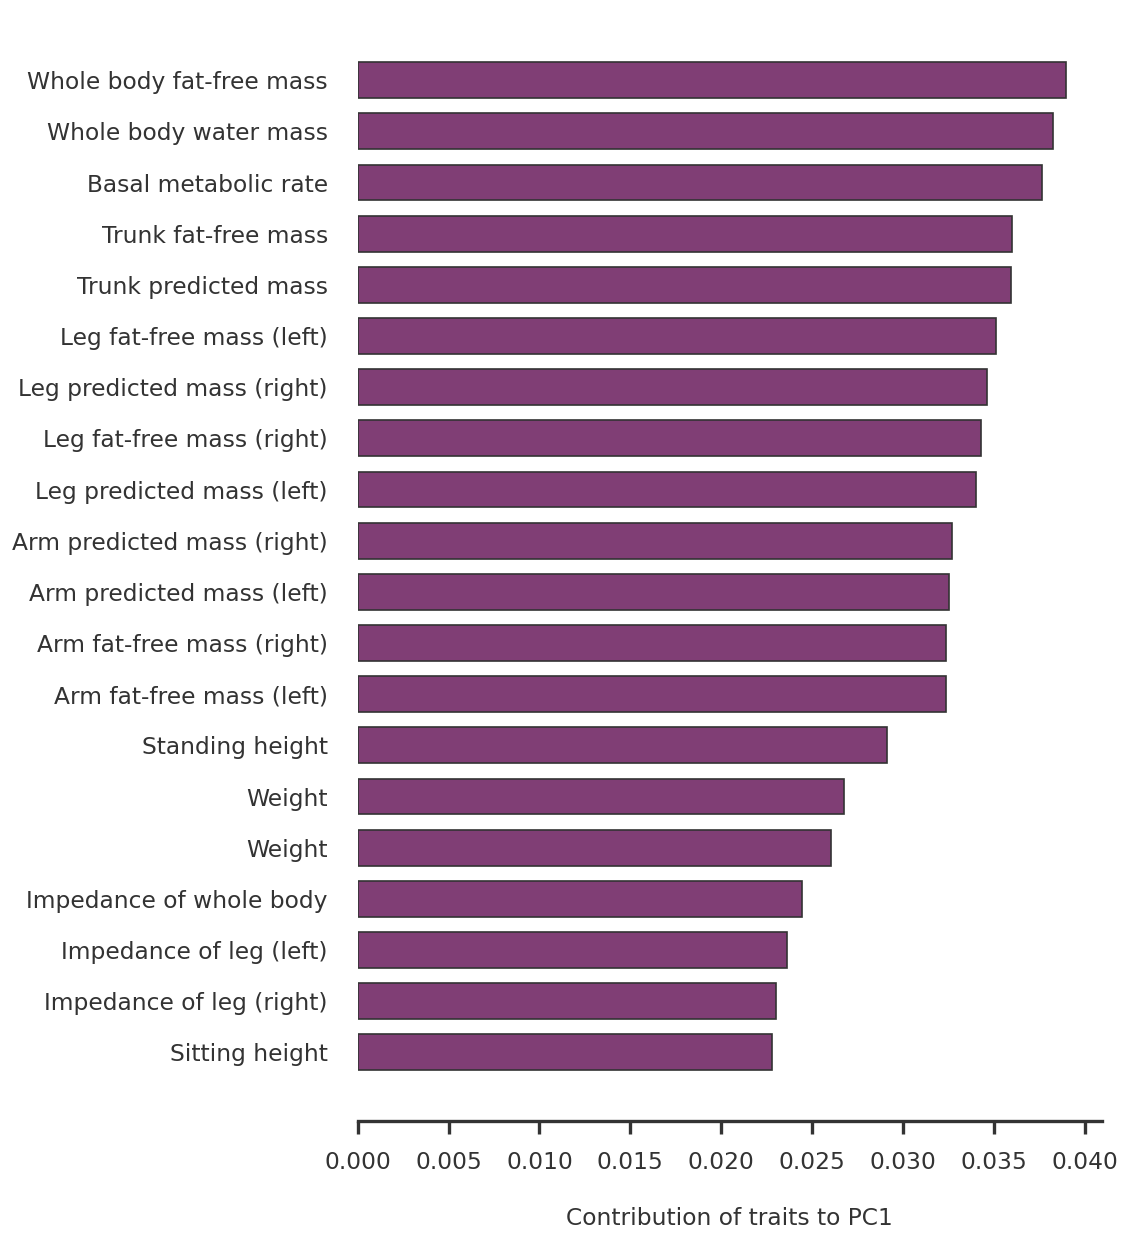

In [95]:
# cos2_pheno         = compute_cos(loadings)
# contribution_pheno = compute_contribution(loadings)
cos2_pheno         = get_cos2_scores(loadings)
contribution_pheno = get_contribution_scores(loadings)

zindex = 2085
trait_indices = np.array(trait_df.index)
tidx = np.searchsorted(trait_indices, zindex - 1)

top_factor = np.argsort(cos2_pheno[tidx,:])[::-1][0]
top_traits_idx = np.argsort(contribution_pheno[:,top_factor])[::-1]
top_traits_name = trait_df.loc[trait_indices[top_traits_idx]]['description'].to_list()
top_traits_score = contribution_pheno[top_traits_idx, top_factor]

fig = plt.figure(figsize = (8, 12))
ax1 = fig.add_subplot(111)

n_plot_traits = 20
xvals = top_traits_score[:n_plot_traits]
yvals = np.arange(n_plot_traits)[::-1]

ax1.barh(yvals, xvals, align = 'center', height = 0.7)
ax1.set_yticks(yvals)
ax1.set_yticklabels(top_traits_name[:n_plot_traits])

for side in ['top', 'right', 'left']:
    ax1.spines[side].set_visible(False)
    
ax1.tick_params(left=False)
ax1.set_xlabel(f"Contribution of traits to PC{top_factor + 1}")

plt.show()

## Importance of components

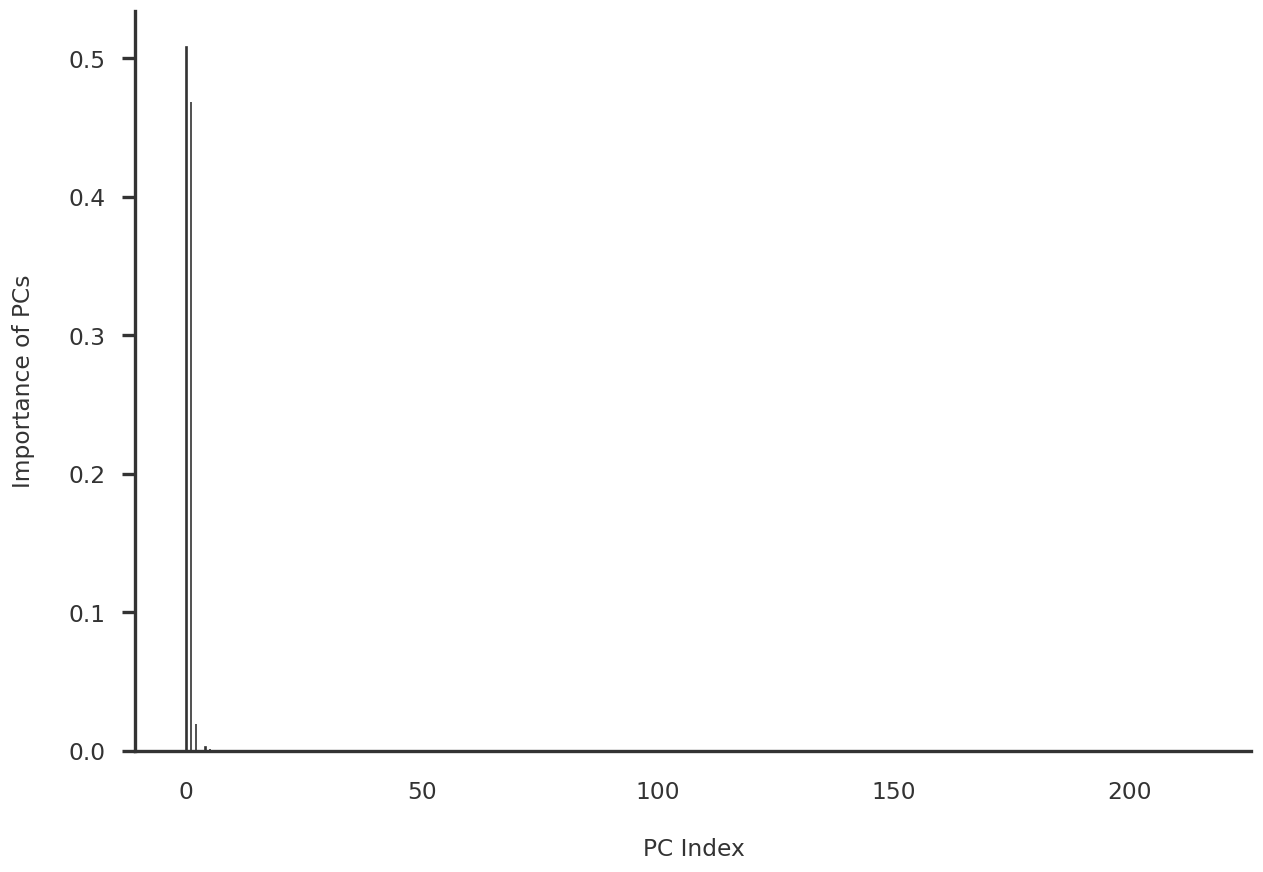

In [96]:
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(111)

xvals = np.arange(cos2_pheno.shape[0])
yvals = cos2_pheno[tidx,:]
ax1.bar(xvals, yvals, align = 'center', width = 0.1)

for side in ['top', 'right']:
    ax1.spines[side].set_visible(False)
    
ax1.tick_params(bottom=False)
ax1.set_ylabel(f"Importance of PCs")
ax1.set_xlabel(f"PC Index")

plt.show()

In [99]:
top_factor_dict = {i : list() for i in range(cos2_pheno.shape[0])}
for i, trait_name in enumerate(trait_df['description'].to_list()):
    top_factor = np.argsort(cos2_pheno[i, :])[::-1][0]
    top_factor_dict[top_factor].append(trait_name)

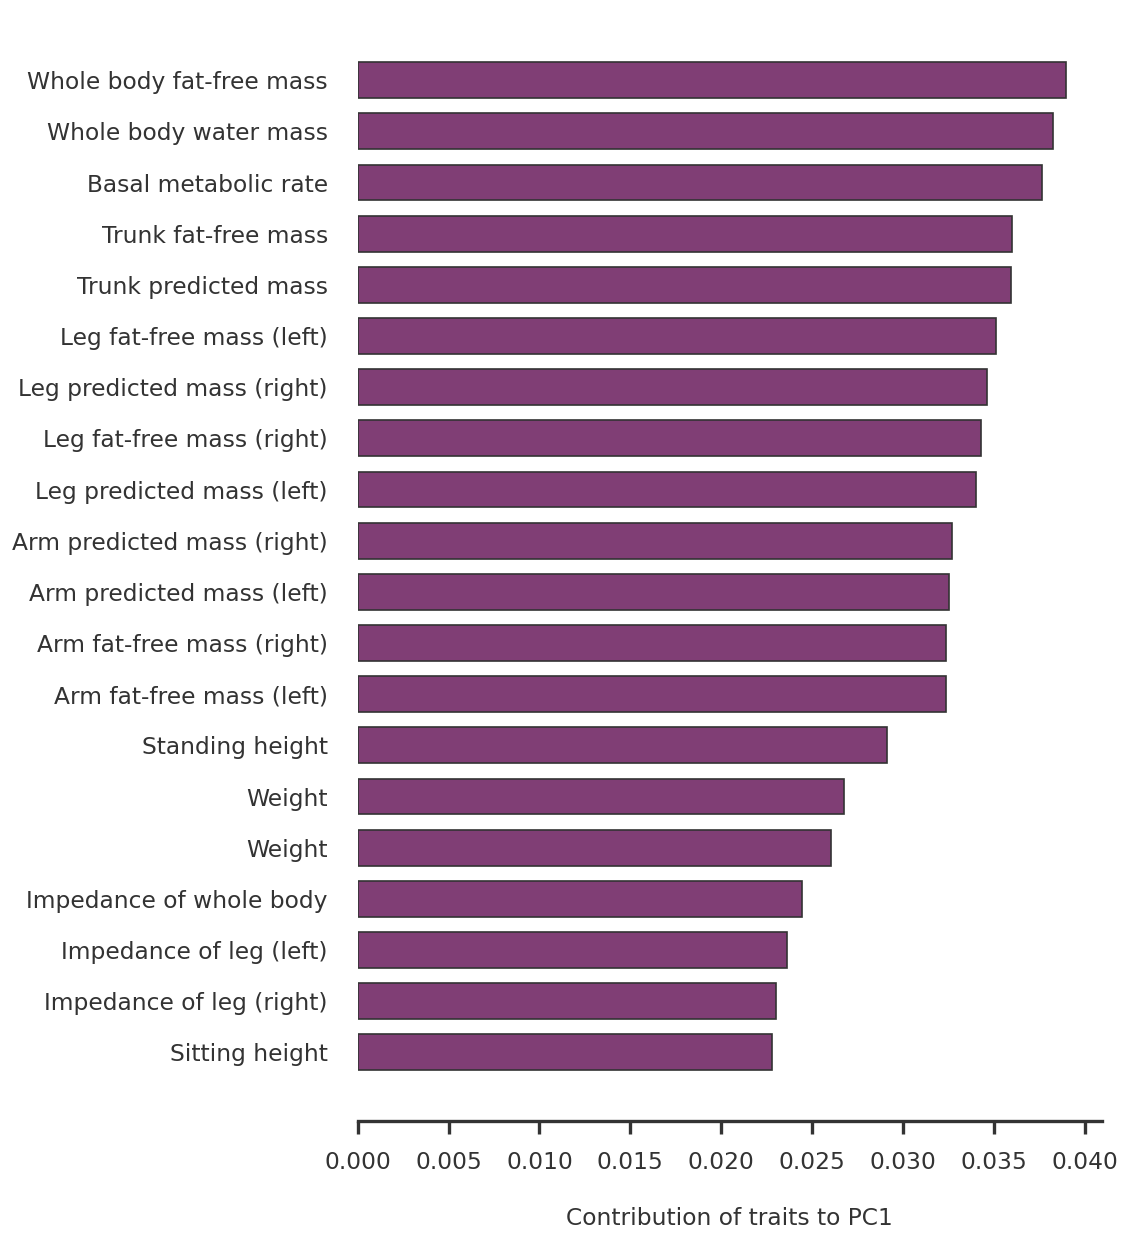

In [102]:
top_factor = 0
top_traits_idx = np.argsort(contribution_pheno[:,top_factor])[::-1]
top_traits_name = trait_df.loc[trait_indices[top_traits_idx]]['description'].to_list()
top_traits_score = contribution_pheno[top_traits_idx, top_factor]

# print (top_factor_dict[top_factor])

fig = plt.figure(figsize = (8, 12))
ax1 = fig.add_subplot(111)

n_plot_traits = 20
xvals = top_traits_score[:n_plot_traits]
yvals = np.arange(n_plot_traits)[::-1]

ax1.barh(yvals, xvals, align = 'center', height = 0.7)
ax1.set_yticks(yvals)
ax1.set_yticklabels(top_traits_name[:n_plot_traits])

for side in ['top', 'right', 'left']:
    ax1.spines[side].set_visible(False)
    
ax1.tick_params(left=False)
ax1.set_xlabel(f"Contribution of traits to PC{top_factor + 1}")

plt.show()

## Which variants are contributing to the top factor?

In [159]:
np.square(eigenvals)[3]

0.011598380845155945

In [160]:
tidx

38

In [161]:
cos2_scores_ = compute_cos(pcomps)

In [172]:
np.sum(cos2_scores_[tidx, :])

0.9999999999999998

In [171]:
np.argsort(cos2_scores_[:, tidx])

array([127,  34,  49, 120, 162,  26,  33, 214,  42, 213, 111,  37, 191,
        12, 109, 137, 128, 215, 167,  69,  92, 113, 112,  63, 193, 188,
       108, 144,   9, 123, 183,  97,  21, 203, 119,  96,  20, 126,  83,
       196,  84,  76, 197,  46, 202, 149,  73, 145, 129, 164, 104,  75,
        87,   4,  64, 107,  25,  27,  74,  79,  11, 103,  41,  99,  15,
       130,  68, 150,  98, 135,  29,  77, 209,  60, 208,  78, 106, 155,
       105, 181,  81,  70, 151, 210, 101, 165,  39, 132,  24, 121,  28,
        91,  54,  30, 117,  62,  36, 171, 176, 148,  94, 170, 140, 195,
        72, 154,  17,  66, 177, 173, 159,  93, 152, 192,  71,  52, 142,
       124, 207, 146, 182, 122,  53, 115, 139,  59,  18, 160, 204,  88,
        31, 161, 134, 163,  90, 178, 200,   0, 110,   3,  35, 138,  51,
       179, 180,  58,  95, 168, 100, 143,  16, 175, 189,  65,  67, 172,
       187, 174, 157,  80, 169, 205,  48, 147,   1,  85,  47,  86, 185,
         5, 186,  89, 190, 198,  38,  61,  55, 125, 158, 136, 20

In [153]:
np.argsort(cos2_scores_)[::-1][0]

0

In [157]:
cos2_scores_[:3]

array([0.50815977, 0.46848446, 0.01892753])

In [ ]:
cos2_scores_

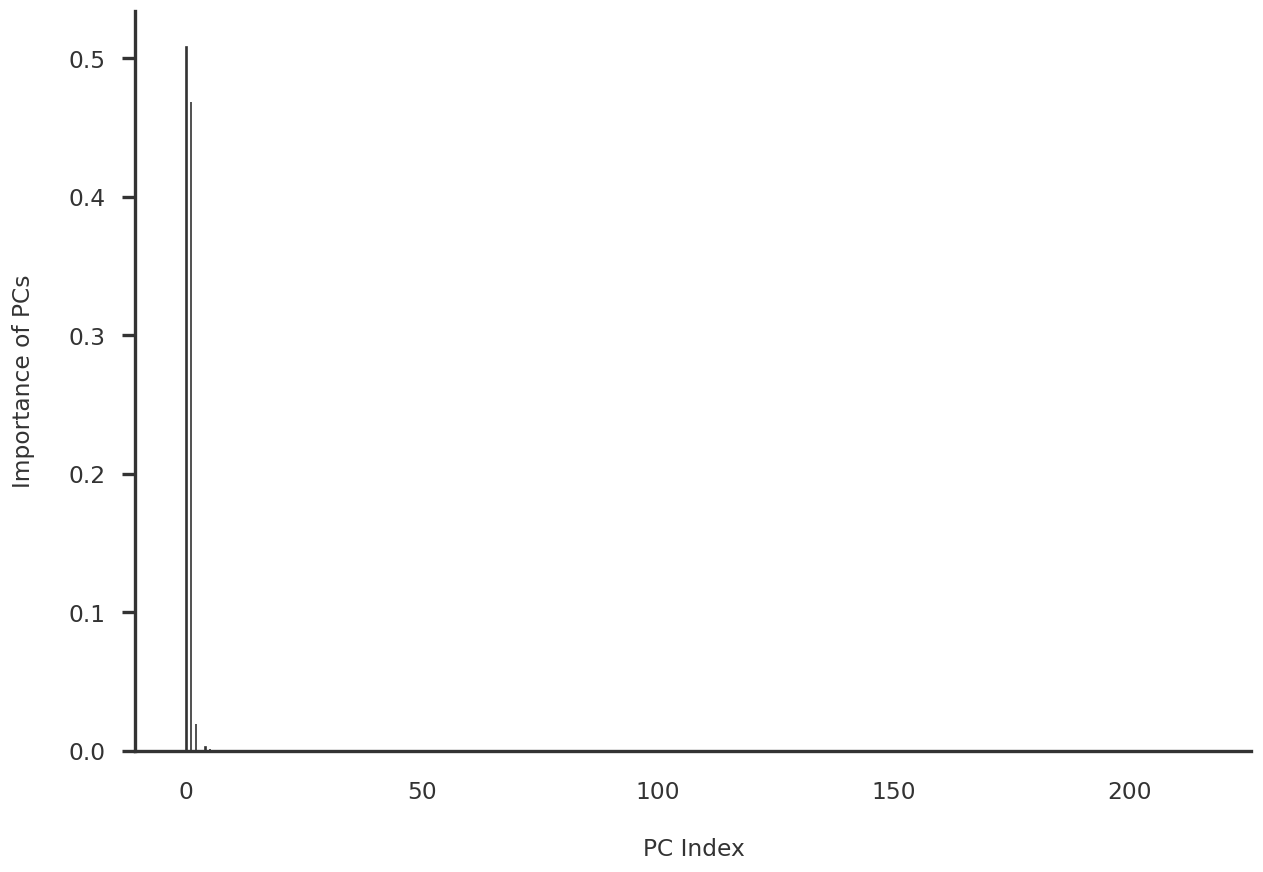

In [149]:
fig = plt.figure(figsize = (12, 8))
ax1 = fig.add_subplot(111)

xvals = np.arange(cos2_scores_.shape[0])
yvals = cos2_scores_
ax1.bar(xvals, yvals, align = 'center', width = 0.1)

for side in ['top', 'right']:
    ax1.spines[side].set_visible(False)
    
ax1.tick_params(bottom=False)
ax1.set_ylabel(f"Importance of PCs")
ax1.set_xlabel(f"PC Index")

plt.show()

In [140]:
std_pcomps = pcomps / np.sqrt(np.var(pcomps[:,:], axis = 0, keepdims = True))
np.sum(np.square(std_pcomps), axis = 0)[3]

216.00000000000006